<a href="https://colab.research.google.com/github/alanagadelha/Python-Training/blob/master/CTP2_atividade_02_gravimetria_Alana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div align="left"> Uso de dados para Ciências da Terra e Ambiental em Python II (CTP2) </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Logo_UFF_%28blue%29.svg/320px-Logo_UFF_%28blue%29.svg.png" alt="drawing" style="width:200px;"/>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRkAFqFW7ctw8U6I5vGdPOpqFpnnExeAUOiIg&s" alt="drawing" width="300";"/>
<img src="https://yt3.googleusercontent.com/ytc/AIdro_lBdDM3DpUsNOOyH-m3vdysjGi1bM9IyPfnchvxfkvymg=s900-c-k-c0x00ffffff-no-rj" alt="drawing" width="200";"/>

Professor: Leonardo Miquelutti

# Atividade 02 - interpolação e visualização de dados de topografia e gravimetria

Nesta atividade, você deverá:
1. selecionar um estado qualquer do Brasil
2. definir as coordenadas geográficas (lat/lon decimal) que compreendem este estado. Deve ficar claro qual estado e coordenadas escolheu.
3. baixar os dados de **topografia** e **gravidade** do [TOPEX](https://topex.ucsd.edu/cgi-bin/get_data.cgi)

Em seguida, você:
1. fará a importação desses dados em `pandas`
2. interpolação em um grid regular com `verde`
3. visualizar com `pyvista`.
  * a topografia do grid do pyvista deve corresponder à topografia obtida com a interpolação
  * o mapa de cores deve corresponder ao dado de gravidade.

É oferecido uma **sugestão** de passo-a-passo para a realização desta tarefa.

## Preparação

In [1]:
!pip install verde pykdtree pyproj harmonica boule -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.8/484.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.3 MB/s eta 0:00:00


A célula abaixo deve ser executada caso o `pyvista` esteja sendo utilizado no **Google Colab**.

In [2]:
# pyvista no COLAB
!pip install -q piglet pyvirtualdisplay pyvista
!apt-get -qq install xvfb

from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As células abaixo são apenas para definir a variável auxiliar `my_path`, que uma string aponta para a pasta na qual estarão os dados.

In [4]:
# your path preffix - COLAB
my_path = '/content'

Importar bibliotecas

In [5]:
import verde as vd
import numpy as np
import pandas as pd
import harmonica as hm
import matplotlib.pyplot as plt
import dask
import pyproj
import pooch

import pyvista as pv
import numpy as np
from pyvista import examples
import matplotlib.pyplot as plt

from pyvista import set_plot_theme
set_plot_theme('document')

plt.rcParams["figure.dpi"] = 120

Definir coordenadas e baixar os dados no site do topex.

Eu, por exemplo, escolhi o estado de SP, e usei as seguintes coordenadas:
* norte: `-19.3`
* sul: `-25.6`
* leste: `-43.7`
* oeste: `-54.6`

In [6]:
# input files
topex_grav = '/content/drive/MyDrive/Colab Notebooks/topex_grav.txt'
#topex_topo = '/content/drive/MyDrive/Colab Notebooks/topex_topo.txt'


**# Comentário Alana #######**
## Baixando os **dados originais de topografia em NETCDF**, para a confeção dos gráficos e dos cálculos!!!!!!!!!!!!

```
url = "https://topex.ucsd.edu/pub/global_topo_1min/topo_19.1.nc"
```




In [7]:
import xarray as xr

url = "https://topex.ucsd.edu/pub/global_topo_1min/topo_19.1.nc"
ds = xr.open_dataset(url)

# Confirme os nomes das coordenadas:
print(ds.coords)  # geralmente 'lat' e 'lon'

lat_name = 'lat' if 'lat' in ds.coords else 'latitude'
lon_name = 'lon' if 'lon' in ds.coords else 'longitude'

# Definir bounding box em graus (lat/lon "normais")

lat_min, lat_max = -31.0, -17.0
lon_min, lon_max = -51.9, -32.9

# Converter lon_min/lon_max para 0–360 se necessário
lons = ds[lon_name]
if float(lons.max()) > 180:  # típico deste dataset
    lon_min_360 = (lon_min + 360) % 360
    lon_max_360 = (lon_max + 360) % 360
else:
    lon_min_360 = lon_min
    lon_max_360 = lon_max

print("Lon recorte (sistema do dataset):", lon_min_360, lon_max_360)

# Ver direção das latitudes (crescente ou decrescente)
print("Primeiras latitudes:", ds[lat_name].values[:5])

# Agora recorta
recorte = ds.sel(
    **{
        lat_name: slice(lat_min, lat_max) if ds[lat_name][0] < ds[lat_name][-1] else slice(lat_max, lat_min),
        lon_name: slice(lon_min_360, lon_max_360)
    }
)

recorte.to_netcdf("topo_SP_regiao_adj.nc")


Coordinates:
  * lat      (lat) float64 77kB -79.99 -79.97 -79.96 ... 79.96 79.97 79.99
  * lon      (lon) float64 173kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Lon recorte (sistema do dataset): -51.9 -32.9
Primeiras latitudes: [-79.99166667 -79.975      -79.95833333 -79.94166667 -79.925     ]


Agora, use a função [`read_fwf`](https://pandas.pydata.org/docs/reference/api/pandas.read_fwf.html) para ler seu dado. Os seguintes argumentos são suficientes:
* `path_to_file` - string com caminho para o local do arquivo
* `names` - lista de strings com os nomes de cada coluna
* `header=None`

In [8]:
grav = pd.read_fwf(topex_grav, header=0)
#topo = pd.read_fwf(topex_topo, header=0)

print("grav.shape:", grav.shape)

print(grav.head())
print(grav.dtypes)



grav.shape: (1057980, 3)
        lon     lat    gz
0  308.0083 -17.003  14.1
1  308.0250 -17.003  16.9
2  308.0417 -17.003  18.8
3  308.0583 -17.003  19.8
4  308.0750 -17.003  19.8
lon    float64
lat    float64
gz     float64
dtype: object


In [9]:
import xarray as xr
import numpy as np
import pandas as pd

# Abre seu recorte
ds = xr.open_dataset("topo_SP_regiao_adj.nc")

# Transformar em DataFrame (explode lat x lon)
topo = ds["z"].to_dataframe().reset_index()
print(topo)



              lat        lon            z
0      -30.991667 -51.891667    19.912239
1      -30.991667 -51.875000    20.032320
2      -30.991667 -51.858333    18.172417
3      -30.991667 -51.841667    18.145544
4      -30.991667 -51.825000    17.952217
...           ...        ...          ...
957595 -17.008333 -32.975000 -4573.998535
957596 -17.008333 -32.958333 -4557.336426
957597 -17.008333 -32.941667 -4534.220703
957598 -17.008333 -32.925000 -4514.890625
957599 -17.008333 -32.908333 -4505.694824

[957600 rows x 3 columns]


A célula abaixo ajusta as **LONGITUDE** para a projeção.

## OBS: A correta transformação nessa célula, é com os valores de longitude!!!

In [10]:
#topo["lon"] -= 360
grav["lon"] -= 360

A célula abaixo confere se os dados possuem mesma dimensão.

In [11]:
#assert grav.shape == topo.shape, "files have different number of data"

In [12]:
n = min(len(grav), len(topo))
print(n)

print(grav.lat.min())
print(grav.lat.max())
print(grav.lon.min())
print(grav.lon.max())

#grav = grav.iloc[:n].reset_index(drop=True)
#topo = topo.iloc[:n].reset_index(drop=True)

#assert grav.shape == topo.shape, "files have different number of data"

print("Total em grav:", len(grav))
print("Total em topo:", len(topo))
print("grav.shape:", grav.shape)
print("topo.shape:", topo.shape)


957600
-31.0069
-17.003
-51.99169999999998
-32.99169999999998
Total em grav: 1057980
Total em topo: 957600
grav.shape: (1057980, 3)
topo.shape: (957600, 3)


Use a função `scatter` para plotar os dados. Defina a cor dos pontos pela variável (topografia/gravidade).

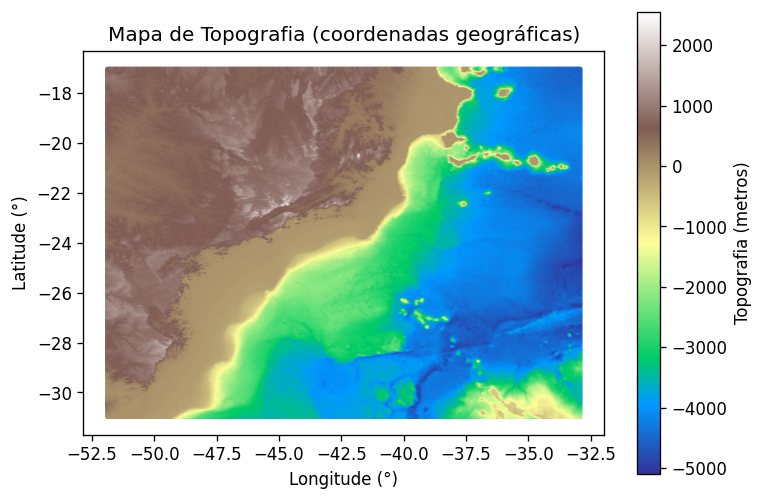

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.scatter(
    topo["lon"],
    topo["lat"],
    c = topo["z"],
    s = 1,
    cmap="terrain"
)

plt.gca().set_aspect("equal")
plt.colorbar(label="Topografia (metros)")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.title("Mapa de Topografia (coordenadas geográficas)")
plt.show()

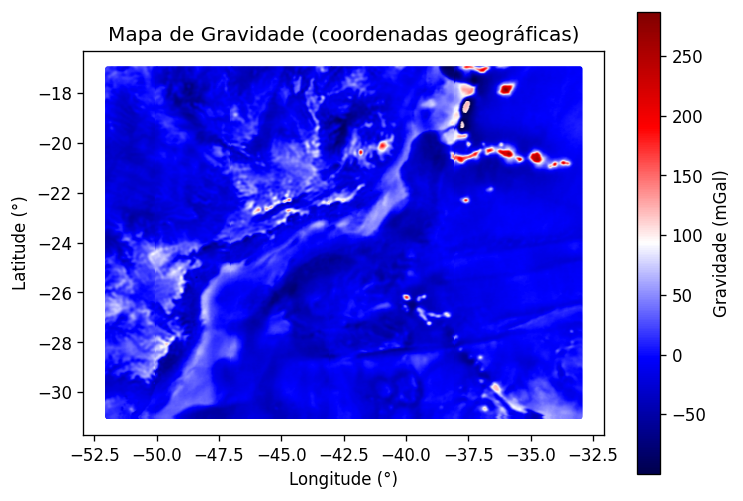

In [14]:
# plot the gravity data
plt.figure(figsize=(7,5))

plt.scatter(
    grav["lon"],
    grav["lat"],
    c = grav["gz"],
    s = 1,
    cmap="seismic"
)

plt.gca().set_aspect("equal")
plt.colorbar(label="Gravidade (mGal)")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.title("Mapa de Gravidade (coordenadas geográficas)")
plt.show()



# Part 1 - reading and gridding the data

Crie um objeto de projeção `Pyproj` usando projeção mercator e a média das latitudes para o argumento `lat_ts`.

In [15]:
# set pyproj projection
lat_media = topo["lat"].mean()
projection = pyproj.Proj(proj="merc",lat_ts=lat_media,datum="WGS84")


E agora faça a projeção das coordenadas geográficas para projetadas.

In [16]:
# and now project it
coordinatesX, coordinatesY = projection(topo["lon"].values, topo["lat"].values)

# saving at DataFrame
topo["coordinatesX"] = coordinatesX
topo["coordinatesY"] = coordinatesY

Agora, faça o mesmo plot que acima, entretanto com coordenadas projetadas.

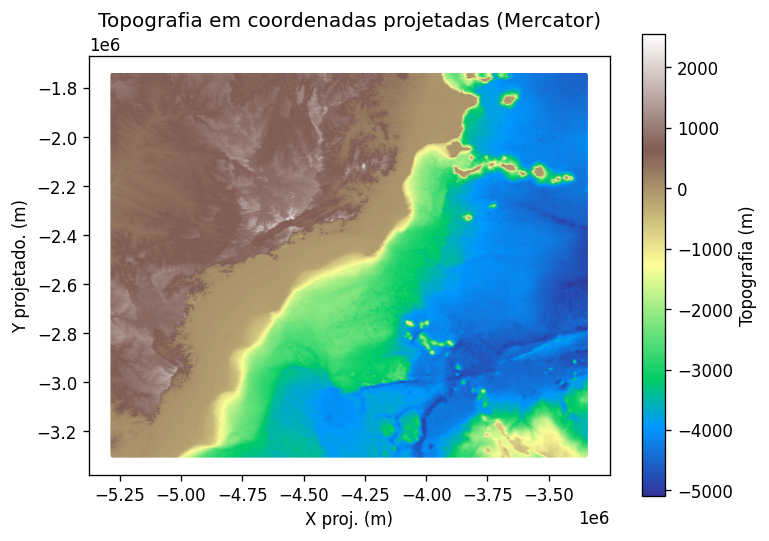

In [17]:
# plot AOI for topography
plt.figure(figsize=(7,5))

tmp = plt.scatter(
    topo["coordinatesX"],
    topo["coordinatesY"],
    c = topo["z"],
    s = 1,
    cmap="terrain"
)

plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="Topografia (m)")
plt.xlabel("X proj. (m)")
plt.ylabel("Y projetado. (m)")
plt.title("Topografia em coordenadas projetadas (Mercator)")
plt.show()


In [18]:
gravX, gravY = projection(grav["lon"].values, grav["lat"].values)

# saving at DataFrame
grav["coordinatesX"] = gravX
grav["coordinatesY"] = gravY


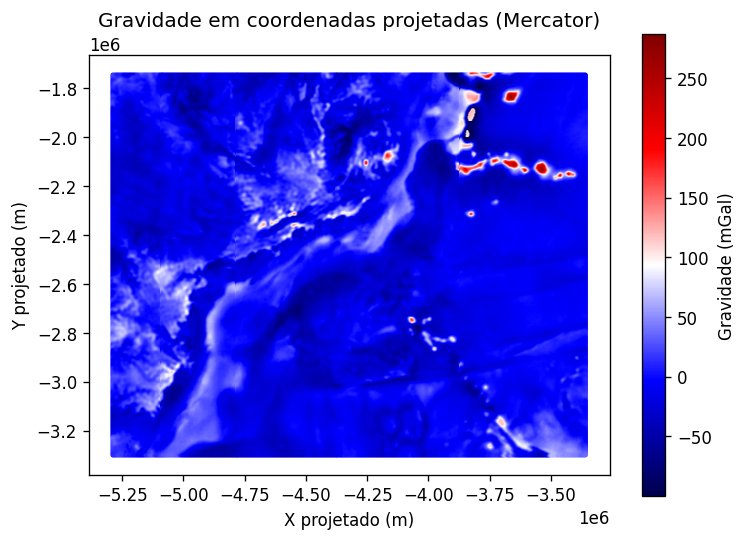

In [19]:
# plot AOI for gravity
plt.figure(figsize=(7,5))

tmp = plt.scatter(
    grav["coordinatesX"],
    grav["coordinatesY"],
    c = grav["gz"],   # gravidade (mGal)
    s = 1,
    cmap="seismic"
)

plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="Gravidade (mGal)")
plt.xlabel("X projetado (m)")
plt.ylabel("Y projetado (m)")
plt.title("Gravidade em coordenadas projetadas (Mercator)")
plt.show()


<a id="reduction"></a>

## Blocked reductions

Crie um redutor usando a função `np.median` como argumento de `verde.BlockReduce`. A escolha do espaçamento é sua e deve ser justificada.

# Comentário Alana####

Pesquisei e vi que dados TOPEX têm resolução ~2km no mar e ~1km em áreas terrestres. Então, escolhi um espaçamento de 10 km para o BlockReduce porque agrega vários pontos sem perder feições regionais e ainda pode reduzir os ruídos.


Vamos aplicar o BlockReduce! Esse comando vai fazer um binning espacial, ou seja, dividir a área em blocos regulares e condensar todos os pontos dentro de cada bloco com o objetivo de reduzir o ruído e a densidade de pontos.  


In [20]:
spacing = 15e3 #10 km

In [21]:
# start a BlockReduce object
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)

In [22]:
# reduce the topography data
coords_topo = (topo["coordinatesX"].values, topo["coordinatesY"].values)
block_coords_topo, block_topo = reducer.filter(coords_topo,topo["z"].values)

# reduce the gravity data
coords_grav = (grav["coordinatesX"].values, grav["coordinatesY"].values)
block_coords_grav, block_grav = reducer.filter(coords_grav,grav["gz"].values)


A célula abaixo verifica se o `shape` de todas as variáveis "blocadas" são iguais.

In [23]:
# check the shape

#Topography
len(block_coords_topo[0]) == len(block_coords_topo[1]) == len(block_topo)

#Gravity
len(block_coords_grav[0]) == len(block_coords_grav[1]) == len(block_grav)


True

Agora, faça o mesmo plot que anteriormente para os dados reduzidos em blocos.

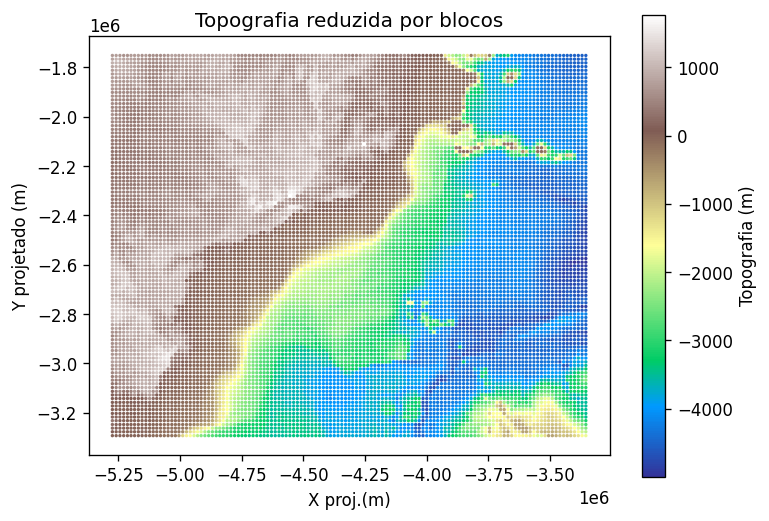

In [24]:
# now plot the reduced data for topography
plt.figure(figsize=(7,5))

plt.scatter(
    block_coords_topo[0],
    block_coords_topo[1],
    c = block_topo,         # topografia reduzida (mediana)
    s = 1,
    cmap="terrain"
)

plt.colorbar(label="Topografia (m)")
plt.gca().set_aspect("equal")
plt.xlabel("X proj.(m)")
plt.ylabel("Y projetado (m)")
plt.title("Topografia reduzida por blocos")
plt.show()


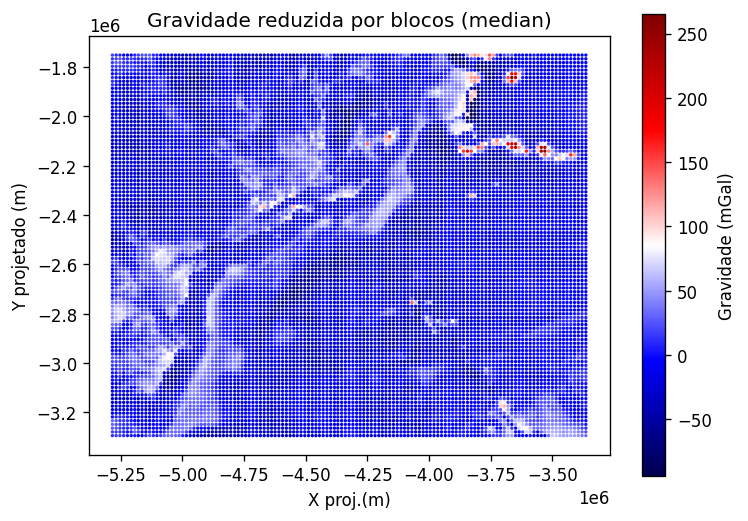

In [25]:
# now plot the reduced data for gravity
plt.figure(figsize=(7,5))

plt.scatter(
    block_coords_grav[0],
    block_coords_grav[1],
    c = block_grav,         # gravidade reduzida (mGal)
    s = 1,
    cmap="seismic"
)

plt.colorbar(label="Gravidade (mGal)")
plt.gca().set_aspect("equal")
plt.xlabel("X proj.(m)")
plt.ylabel("Y projetado (m)")
plt.title("Gravidade reduzida por blocos (median)")
plt.show()


<a id="gridding"></a>

## Gridding with splines

Now that we have decimated data, we can fit a bi-harmonic spline model to it and use the model to predict observations (which is how we do interpolation).
The spline model is:

$$g(\mathbf{x}) = \|\mathbf{x}\|^2 \left(\log \|\mathbf{x}\| - 1\right)$$

**WARNING**:
The Verde spline interpolation can be quite heavy on RAM usage (scaling with N²) so be careful using small blocks in the decimation process.
We are actively working to break out of these limits but that is still a reseach question being tackled at the [Computer-Oriented Geoscience Lab](https://www.compgeolab.org/).

Inicie um objeto `verde.Spline()` para topografia e outro para gravidade. Eles devem ser diferentes, pois ajustarão modelos a conjuntos distintos de dados.

#Comentário Alana######:

Quando rodei o comando abaixo, a memória RAM estourou e o Colab não rodou mais.

## fit data with spline
**spline_topo.fit(block_coords_topo, block_topo)**
**spline_grav.fit(block_coords_grav, block_grav)**

#################################

---


Então, dei um passo atrás e diminui a resolução espacial de 10 km para 15 km.
**spacing = 15e3 #10 km**

---

 O "verde.Spline" monta uma matriz densa que cresce como N² em RAM (onde N é o número de pontos usados na spline).

Então, mesmo com BlockReduce, se ainda tiver muitos pontos ou um grid muito fino, o Colab estoura a memória.

## Depois de corrigir isso, fiz o 'fit + grid + plot'. E tudo está abaixo!!!! ✅

In [26]:
# start a Spline object for topo and for grav

spline_topo = vd.Spline()
spline_grav = vd.Spline()


Use o método `spline.fit` para ajustar o modelo *spline* a ambos conjunto de dados.

In [27]:
# fit data with spline
spline_topo.fit(block_coords_topo, block_topo)
spline_grav.fit(block_coords_grav, block_grav)


Spline(mindist=0)

Agora, crie um grid de dados no formato `xarray` com o método `spline.grid`.

# #####Comentário Alana

##Fiz **DOIS** teste para plotar.

1. O primeiro teste foi usando o spacing=10e3;

2. O Segundo foi usando o shape. Neste segundo as plotagens ficaram melhores e porque isso aconteceu, o shape:

* Mantém boa resolução;
* Ocupa pouca memória;
* É rápido de plotar; e
* É ideal para spline!!!!!!!!!!!

In [28]:
# região única que cobre topo e grav
xmin = min(block_coords_topo[0].min(), block_coords_grav[0].min())
xmax = max(block_coords_topo[0].max(), block_coords_grav[0].max())
ymin = min(block_coords_topo[1].min(), block_coords_grav[1].min())
ymax = max(block_coords_topo[1].max(), block_coords_grav[1].max())

region = [xmin, xmax, ymin, ymax]
print("region:", region)


region: [np.float64(-5283460.91357347), np.float64(-3355264.77852836), np.float64(-3294467.9806012465), np.float64(-1751385.9804345975)]


In [84]:
# define your spacing (or number of points)

#spacing = 10e3
shape = (100, 100)

# create the grid for topography
region_topo = [block_coords_topo[0].min(), block_coords_topo[0].max(),
               block_coords_topo[1].min(), block_coords_topo[1].max()]
grid_topo = spline_topo.grid(region=region, spacing=spacing)
print("\nGRID_TOPOGRAPHY", grid_topo)


# create the grid for gravity
region_grav = [block_coords_grav[0].min(), block_coords_grav[0].max(),
               block_coords_grav[1].min(), block_coords_grav[1].max()]
grid_grav = spline_grav.grid(region=region, spacing=spacing)
print("\nGRID_GRAVITY", grid_grav)



GRID_TOPOGRAPHY <xarray.Dataset> Size: 110kB
Dimensions:   (northing: 104, easting: 130)
Coordinates:
  * northing  (northing) float64 832B -3.294e+06 -3.279e+06 ... -1.751e+06
  * easting   (easting) float64 1kB -5.283e+06 -5.269e+06 ... -3.355e+06
Data variables:
    scalars   (northing, easting) float64 108kB 42.2 13.19 ... -4.548e+03
Attributes:
    metadata:  Generated by Spline(mindist=0)

GRID_GRAVITY <xarray.Dataset> Size: 110kB
Dimensions:   (northing: 104, easting: 130)
Coordinates:
  * northing  (northing) float64 832B -3.294e+06 -3.279e+06 ... -1.751e+06
  * easting   (easting) float64 1kB -5.283e+06 -5.269e+06 ... -3.355e+06
Data variables:
    scalars   (northing, easting) float64 108kB 12.3 15.42 ... -4.706 -3.25
Attributes:
    metadata:  Generated by Spline(mindist=0)


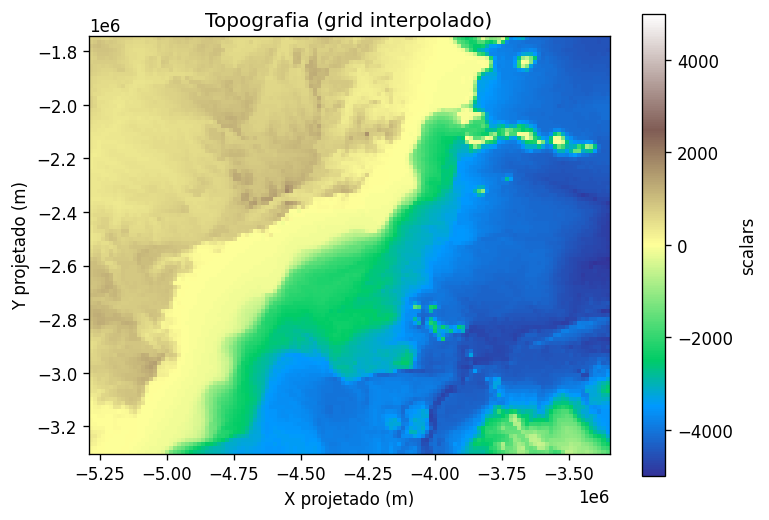

In [85]:
# plot the topography data with xarray

# plotando a variável de dados 'scalars'
var_topo = list(grid_topo.data_vars)[0]

plt.figure(figsize=(7,5))
grid_topo[var_topo].plot(cmap="terrain")
plt.gca().set_aspect("equal")
plt.title("Topografia (grid interpolado)")
plt.xlabel("X projetado (m)")
plt.ylabel("Y projetado (m)")
plt.show()


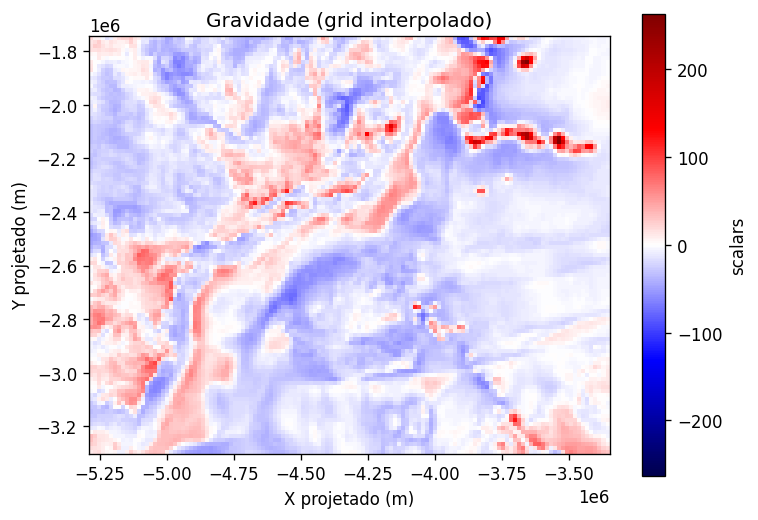

In [86]:
# plot the gravity data with xarray
var_grav = list(grid_grav.data_vars)[0]

plt.figure(figsize=(7,5))
grid_grav[var_grav].plot(cmap="seismic").s=4
plt.gca().set_aspect("equal")
plt.title("Gravidade (grid interpolado)")
plt.xlabel("X projetado (m)")
plt.ylabel("Y projetado (m)")
plt.show()


# Part 2 - Compute Bouguer Gravity Disturbance

O dado de gravimetria que foi baixado do TOPEX corresponde ao *Distúrbio de Gravidade* (gravity disturbance). A partir deste dado, você deve obter o *Distúrbio de Gravidade Bouguer* (Bouguer Gravity Disturbance).
Você deve:
* modelar a topografia com prismas
* computar o efeito gravitacional da camada de prismas
* computar o Distúrbio de Gravidade Bouguer
* plotar o resultado. A figura abaixo mostra o resultado para o estado de SP 👇

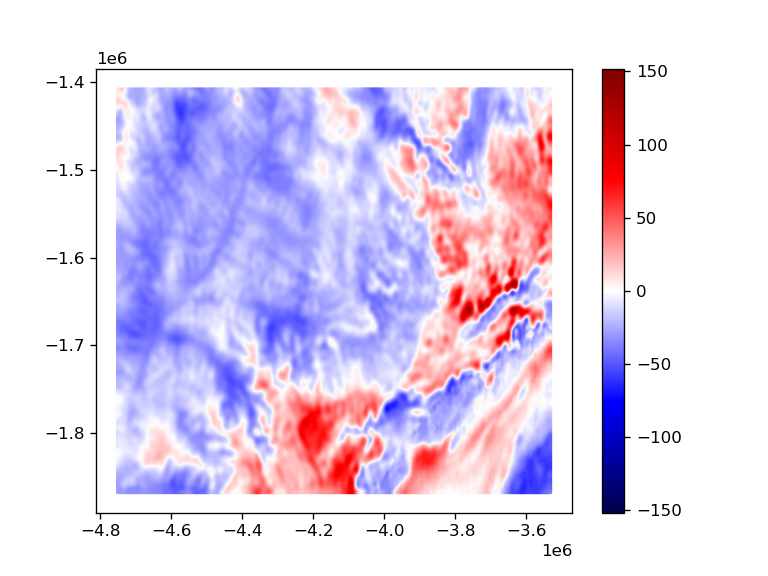

In [87]:
import pandas as pd

# 1 — Extrair os DataArrays de topografia e gravidade
topo_name = list(grid_topo.data_vars)[0]
grav_name = list(grid_grav.data_vars)[0]

topo_da = grid_topo[topo_name]
grav_da = grid_grav[grav_name]

# 2 — Converter cada um para DataFrame (coords + valores)
df_topo = topo_da.to_dataframe(name="elevation").reset_index()
df_grav = grav_da.to_dataframe(name="gravity_disturbance").reset_index()

# 4 — Fazer o merge usando sempre as mesmas coordenadas
data = df_topo.merge(df_grav, on=["easting", "northing"])

data.head(), data.columns


(       northing       easting  elevation  gravity_disturbance
 0 -3.294468e+06 -5.283461e+06  42.202325            12.299997
 1 -3.294468e+06 -5.268514e+06  13.189080            15.416534
 2 -3.294468e+06 -5.253566e+06   8.462144            17.817953
 3 -3.294468e+06 -5.238619e+06   0.077795             9.149289
 4 -3.294468e+06 -5.223672e+06  -6.193351             4.180781,
 Index(['northing', 'easting', 'elevation', 'gravity_disturbance'], dtype='object'))

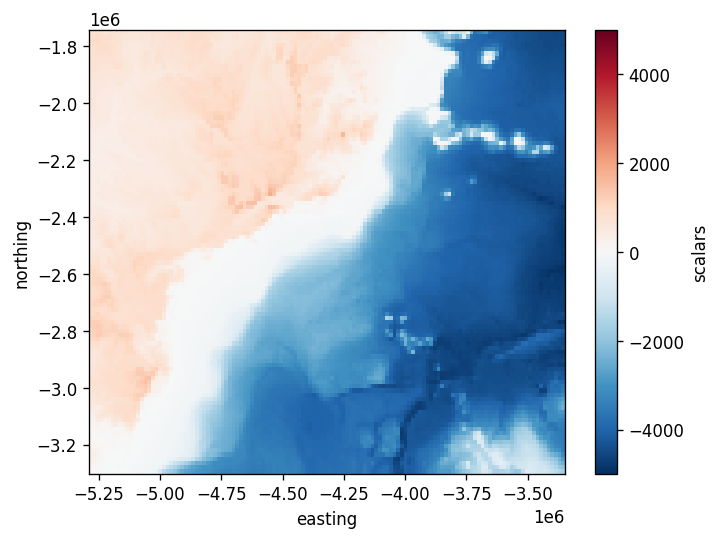

In [88]:
# Transformar o grid de topografia para coordenadas planas (easting/northing)
topo_plain = topo_da

topo_plain.plot()

In [89]:
# crie os primas da topografia
# superfície original (topografia em metros)
surface_orig = topo_plain.values

# manter apenas topografia positiva (acima de 0 m)
surface = np.maximum(surface_orig, 0.0)

prisms_centers = (topo_plain.easting, topo_plain.northing)
surface = topo_plain.values

# Superfície da topografia (valores em metros)
surface = topo_plain.values

In [90]:
# crie um np.array de densidades kg/m³
density = 2670 * np.ones_like(surface)

In [91]:
# crie o modelo topográfico de prismas
topo_prisms = hm.prism_layer(prisms_centers,surface=surface,reference=0,
                             properties={"density": density})
topo_prisms

<xarray.Dataset> Size: 326kB
Dimensions:   (northing: 104, easting: 130)
Coordinates:
  * northing  (northing) float64 832B -3.294e+06 -3.279e+06 ... -1.751e+06
  * easting   (easting) float64 1kB -5.283e+06 -5.269e+06 ... -3.355e+06
    top       (northing, easting) float64 108kB 42.2 13.19 8.462 ... 0.0 0.0 0.0
    bottom    (northing, easting) float64 108kB 0.0 0.0 ... -4.54e+03 -4.548e+03
Data variables:
    density   (northing, easting) float64 108kB 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

In [92]:
# defina as coordenadas onde vamos calcular o efeito gravitacional dos prismas
coordinates = (data.easting.values,
               data.northing.values,
               data.elevation.values)

In [93]:
# calcule "g_z" com o acessor "prism_layer"
result_si = topo_prisms.prism_layer.gravity(coordinates,field="g_z")
result = result_si * 1e5


In [94]:
# calcule o distúrbio
bouguer_disturbance = data.gravity_disturbance - result

data = data.assign(bouguer_disturbance=bouguer_disturbance)
data

northing       easting    elevation  gravity_disturbance  \
0     -3.294468e+06 -5.283461e+06    42.202325            12.299997   
1     -3.294468e+06 -5.268514e+06    13.189080            15.416534   
2     -3.294468e+06 -5.253566e+06     8.462144            17.817953   
3     -3.294468e+06 -5.238619e+06     0.077795             9.149289   
4     -3.294468e+06 -5.223672e+06    -6.193351             4.180781   
...             ...           ...          ...                  ...   
13515 -1.751386e+06 -3.415054e+06 -4504.971086            -2.987955   
13516 -1.751386e+06 -3.400107e+06 -4519.207939            -2.060982   
13517 -1.751386e+06 -3.385159e+06 -4533.469105            -4.203342   
13518 -1.751386e+06 -3.370212e+06 -4539.565441            -4.706353   
13519 -1.751386e+06 -3.355265e+06 -4548.173212            -3.250436   

       bouguer_disturbance  
0            -4.789494e+05  
1            -1.547297e+05  
2            -1.027699e+05  
3            -9.626127e+03  
4             5.985460e+04  
...                    ...  
13515         4.554586e+07  
13516         4.559049e+07  
13517         4.555859e+07  
13518         4.520882e+07  
13519         4.297833e+07  

[13520 rows x 5 columns]

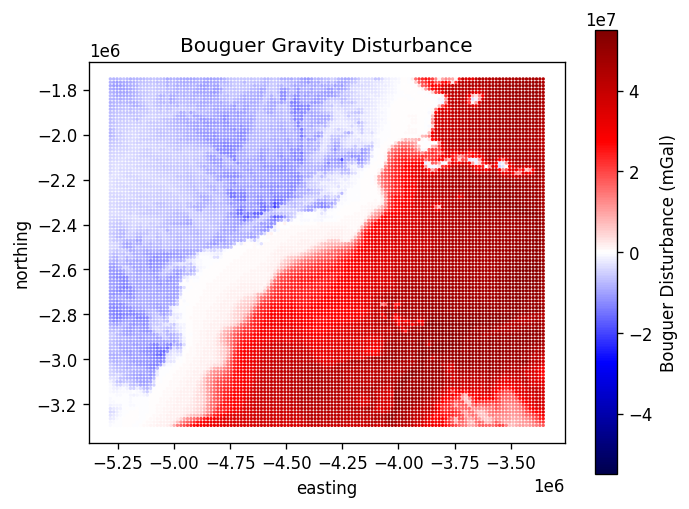

In [95]:
maxabs = vd.maxabs(data.bouguer_disturbance)
tmp = plt.scatter(data.easting, data.northing, c=data.bouguer_disturbance,
                  s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="Bouguer Disturbance (mGal)")
plt.title("Bouguer Gravity Disturbance")
plt.xlabel("easting")
plt.ylabel("northing")
plt.show()

# Part 3 - Creating a mesh with pyvista

Nesta seção, você vai criar um mesh com a biblioteca pyvista. A topografia do seu UniformGrid() (ou qualquer outro tipo de grid à sua escolha) deve corresponder à topografia do dado. E o dado mostrado sobre o mesh deve ser o dado de gravidade. A figura abaixo mostra o resultado esperado para o estado de SP.

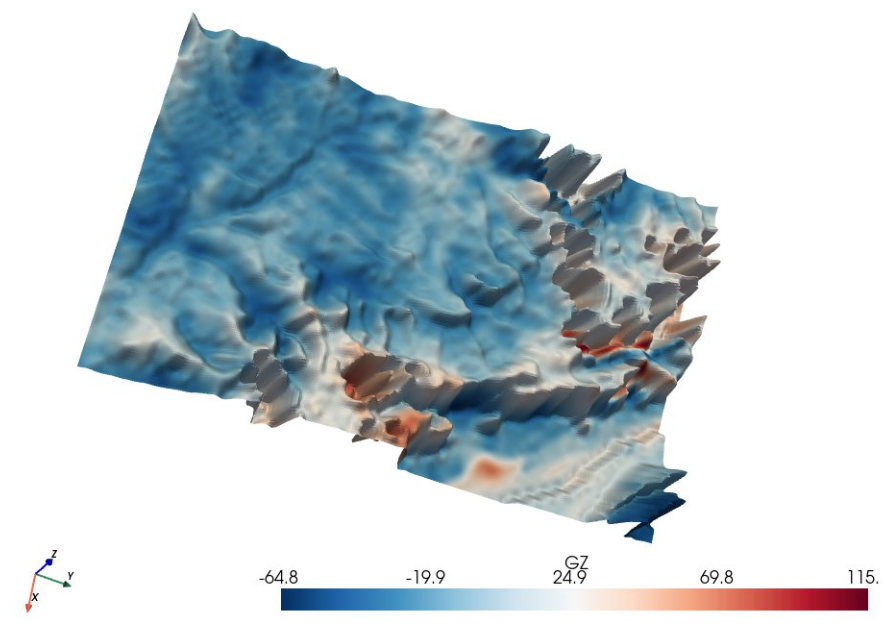

No exemplo acima, eu criei uma superfície (não um volume), pois defini a dimensão em *z* como `=1` ao definir a variável `grid.dimensions`.

Comece iniciando um `pyvista.UniformGrid()` ou qualquer outro de sua escolha.

In [97]:
# Extrair DataArrays
topo = list(grid_topo.data_vars.values())[0]
grav = list(grid_grav.data_vars.values())[0]

# Coordenadas 1D
easting = topo.easting.values   # eixo leste-oeste (X)
northing = topo.northing.values # eixo norte-sul (Y)

# Matrizes 2D (ny, nx)
topo_2d = topo.values
grav_2d = grav.values
ny, nx = topo_2d.shape   # ny = len(northing), nx = len(easting)

print("ny, nx:", ny, nx)

# Criar o grid (ImageData = UniformGrid moderno)
grid = pv.ImageData()

# Dimensões = número de pontos = shape + 1 (CELL DATA)
grid.dimensions = (nx + 1, ny + 1, 1)   # (n_points_x, n_points_y, n_points_z)



ny, nx: 104 130


In [98]:
# Set the grid dimensions: shape + 1 because we want to inject our values on
# the CELL data, so this is the number of points in the mesh

grid.cell_data["gravity"] = grav_2d.ravel(order="C")
grid.cell_data["elevation"] = topo_2d.ravel(order="C")


Defina na célula abaixo as dimensões do grid, **lembrando que deve ser feito `shape + 1` pois queremos injetar os dados nas células (`CELL DATA`)**.

Vale a pena ressaltar que para ser criada um `pv.UniformGrid` é necessário uma `tuple` com os valores de (`nx`,`ny`,`nz`), mesmo que algum seja igual a 1.

Agora, enquanto o dado ainda é um `UniformGrid()`, adicione a origem a ele a sua origem com `grid.origin = (x0, y0, z0)`, nas quais:
* `x0` deve ser o valor **máximo** da coordenada *norte-sul* projetada
* `y0` deve ser o valor **mínimo** da coordenada *leste-oeste* projetada
* `z0 = 0`

Tais convenções acima devem ser adotadas para compatibilizar os sistemas de referência utilizados em padrão pela biblioteca `verde` e `pyvista`.

In [99]:
# Origem = canto inferior esquerdo do domínio
#  X → Easting (EW), Y → Northing (NS)
x0 = easting.min()
y0 = northing.min()
z0 = 0.0
grid.origin = (x0, y0, z0)
print("Origin set to:", grid.origin)


Origin set to: (-5283460.91357347, -3294467.9806012465, 0.0)


Como sabemos, a função `spline.grid()`, utilizada para se obter os *xarray DataSet* `grid_topo` e `grid_grav`, retorna um grid **regularmente espaçado**. Calcule o espaçamento real entre os nós do grid; ou seja, verifique se o `spacing` fornecido é o espaçamento real entre os nós do grid. Essa informação deve ser usada para definir `grid.spacing`.

**ATENÇÃO** aos sinais utilizados para definir o espaçamento.

In [100]:
# Spacing POSITIVO ao longo de cada eixo

real_spacing_east = np.diff(easting).mean()
real_spacing_north = np.diff(northing).mean()

print("real_spacing_east:", real_spacing_east)
print("real_spacing_north:", real_spacing_north)

grid.spacing = (real_spacing_east,  # X = EW
                real_spacing_north, # Y = NS
                1.0)
print("grid.spacing:", grid.spacing)



real_spacing_east: 14947.256860814805
real_spacing_north: 14981.378642394651
grid.spacing: (14947.256860814805, 14981.378642394651, 1.0)


Uma vez que definiu `grid.origin` e `grid.spacing`, imprima o grid e confira se:
* `X Bounds` corresponde aos limites EW
* `Y Bounds` corresponde aos limites NS

Caso não, confira:
* se não trocou EW e NS de posição em algum momento
* se alterar o sinal do espaçamento acerta os valores

In [101]:
# Ver o grid
print(grid)

# Limites reais das coordenadas do xarray
print("Easting (EW) min/max :", easting.min(), easting.max())
print("Northing (NS) min/max:", northing.min(), northing.max())


ImageData (0x7f0a5425c8e0)
  N Cells:      13520
  N Points:     13755
  X Bounds:     -5.283e+06, -3.340e+06
  Y Bounds:     -3.294e+06, -1.736e+06
  Z Bounds:     0.000e+00, 0.000e+00
  Dimensions:   131, 105, 1
  Spacing:      1.495e+04, 1.498e+04, 1.000e+00
  N Arrays:     2
Easting (EW) min/max : -5283460.91357347 -3355264.77852836
Northing (NS) min/max: -3294467.9806012465 -1751385.9804345975


In [102]:
# esta célula serve para auxiliar na conferência das coordenadas (X Bounds, Y Bounds) do grid
print(
    grid_topo.easting.values.min(),
    grid_topo.easting.values.max(),
    grid_topo.northing.values.min(),
    grid_topo.northing.values.max(),
)

-5283460.91357347 -3355264.77852836 -3294467.9806012465 -1751385.9804345975


Agora:
1. adicione os dados (escalares) de topografia e gravidade.
2. transforme a topografia do grid (ou seja, os valores atribuídos à coordenada `z` das células) na topografia "real" usando o método `warp_by_scalar()`.
  * use o argumento `factor` para compensar as grandes diferenças entre as altitudes de uma área tão grande e deixar o grid mais "visualizável". No exemplo acima utilizei `factor = 1e2`.
3. deixe os dados de gravidade ativos para serem plotados

In [178]:
# 1. add topo and grav data to the mesh

grid.cell_data["elevation"] = topo_2d.ravel(order="C")
grid.cell_data["gravity"]   = grav_2d.ravel(order="C")

# 2) Converter CELL DATA → POINT DATA
grid = grid.cell_data_to_point_data()

# 2. warp_by_scalar
#    factor controla o exagero vertical (para visualização)
surface = grid.warp_by_scalar(scalars="elevation",factor=1e2)

# 3. set active scalars
surface.set_active_scalars("gravity")

(<FieldAssociation.POINT: 0>,
 pyvista_ndarray([12.29999737, 13.8582658 , 16.61724384, ..., -4.4548473 ,
                  -3.97839433, -3.25043559]))

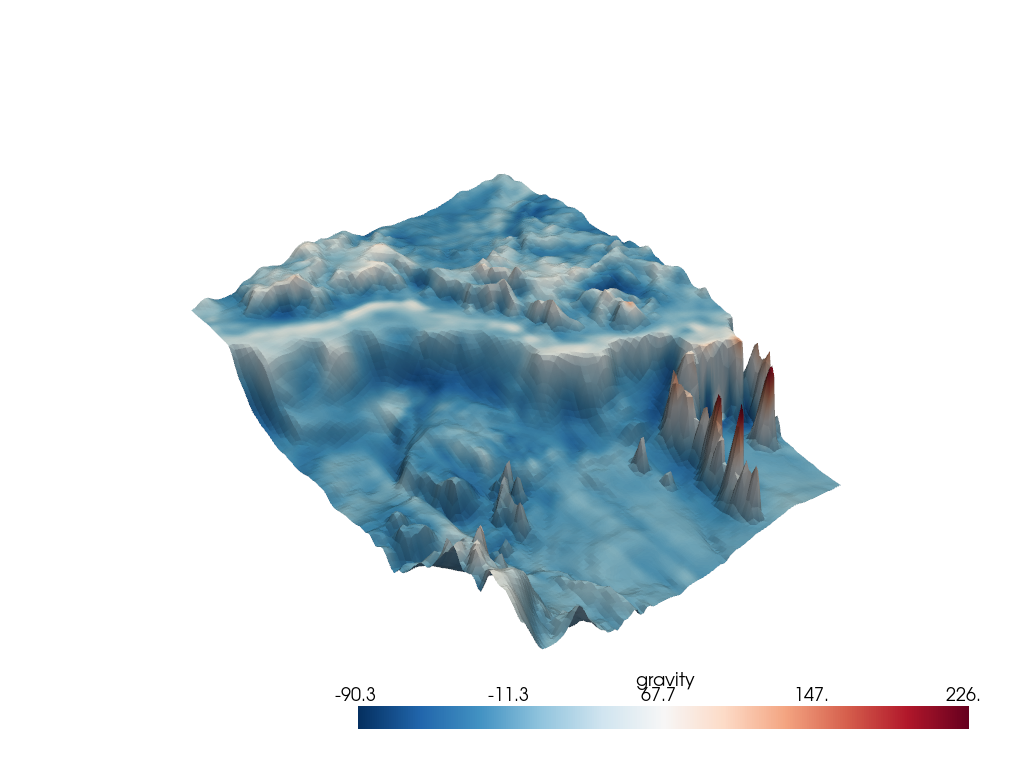

StructuredGrid (0x7f09ed043400)
  N Cells:      13520
  N Points:     13755
  X Bounds:     3.591e+06, 5.775e+06
  Y Bounds:     7.926e+05, 2.664e+06
  Z Bounds:     -4.954e+05, 1.604e+05
  Dimensions:   131, 105, 1
  N Arrays:     2

In [180]:
import pyvista as pv

# garantir backend de notebook
#pv.set_jupyter_backend("static")   # ou "client", se você quiser interação

plotter = pv.Plotter(notebook=True)
plotter.add_mesh(
    surface,
    cmap="RdBu_r",
    show_edges=False,
)
plotter.show()
surface.rotate_z(85, inplace=True)